In [2]:
# from matplotlib import style
# style.use('fivethirtyeight')

# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [4]:
#inspect the tables
inspector = inspect(engine)
tables = inspector.get_table_names()
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Declare a Base using `automap_base()`
base = automap_base()
# Use the Base class to reflect the database tables
base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(list(base.classes))

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(func.max(measurement.date)).first()
recent

('2017-08-23',)

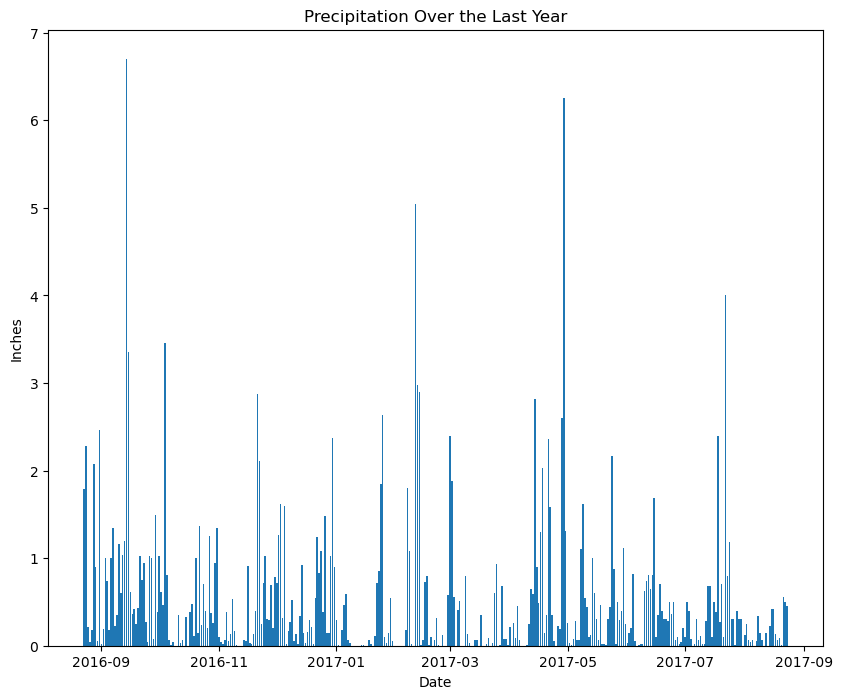

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
prec = session.query(measurement.prcp, measurement.date, measurement.station).filter(measurement.date >= prev_year).order_by(measurement.date.asc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prec, columns=['precipitation', 'date', 'station'])
df.head()

# Sort the dataframe by date
df["date"] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,8))
plt.bar(df.date, df.precipitation)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Last Year')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
num_station = session.query(station).count()
num_station

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(measurement.station, func.count(measurement.id).label('num_stations')) \
                 .group_by(measurement.station) \
                 .order_by(func.count(measurement.id).desc()) \
                 .all()
df2 = pd.DataFrame(results)
df2

,station,num_stations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
query3 = """
    SELECT 
    MIN(tobs) AS min_temperature,
    MAX(tobs) AS max_temperature,
    AVG(tobs) AS avg_temperature
    FROM measurement
    WHERE station = 'USC00519281';
"""
df3 = pd.read_sql(text(query3), con=engine)
df3

,min_temperature,max_temperature,avg_temperature
0,54.0,85.0,71.663781


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results1 = session.query(func.min(measurement.tobs).label('min_value'),
                            func.max(measurement.tobs).label('max_value'),
                            func.avg(measurement.tobs).label('avg_value')).filter(measurement.station == 'USC00519281').one()
df_avg = pd.DataFrame([results1], columns=['min_value', 'max_value', 'avg_value'])
df_avg

,min_value,max_value,avg_value
0,54.0,85.0,71.663781


Text(0, 0.5, 'Frequency')

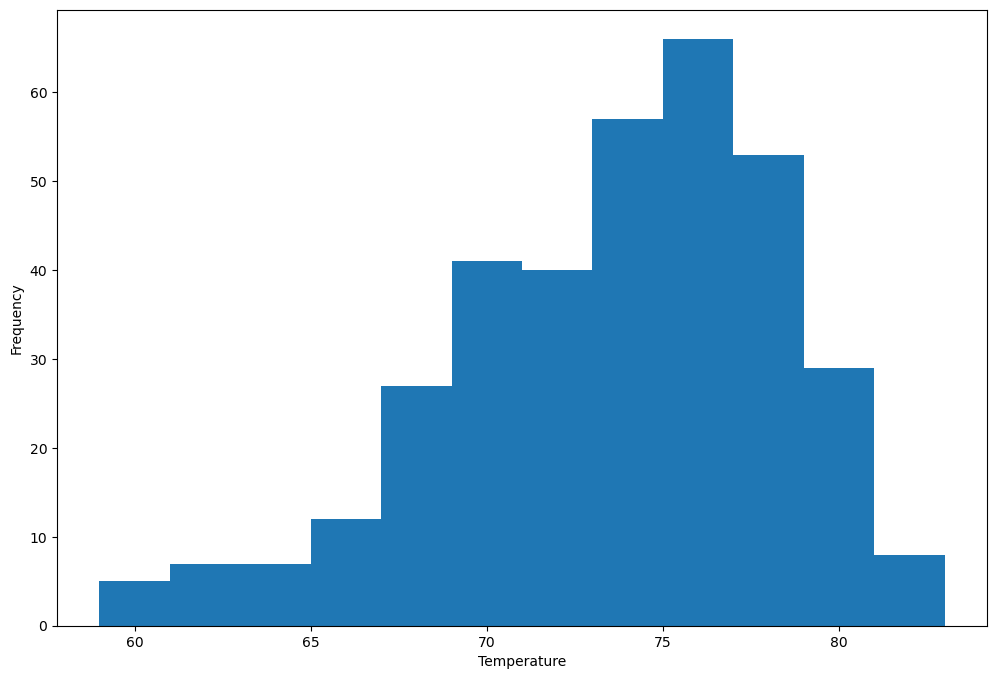

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_plot = session.query(measurement.tobs).filter(measurement.date >= prev_year).filter(measurement.station == 'USC00519281')
df4 = pd.DataFrame(result_plot)
plt.figure(figsize=(12,8))
plt.hist(df4.tobs, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close Session

In [18]:
# Close Session
session.close()
